In [1]:
import random
import gym
from gym import error, spaces
import pandas as pd
import numpy as np
from enum import Enum
from stockstats import StockDataFrame
# from tensorboardX import SummaryWriter

import gym
import datetime as dt
import matplotlib.pyplot as plt

# from stable_baselines.common.policies import MlpPolicy, CnnPolicy, MlpLstmPolicy, ActorCriticPolicy, LstmPolicy
# from stable_baselines.common.vec_env import DummyVecEnv
# from stable_baselines import PPO2, PPO1, A2C, DQN, TD3, SAC

# from stable_baselines3.common.policies import MlpPolicy
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

from sklearn import preprocessing

import pandas as pd

In [2]:
from lutils.stock import LTdxHq

In [3]:
MAX_ACCOUNT_BALANCE = 2147483647
MAX_NUM_SHARES = 2147483647
MAX_NUM_AMOUNTS = 2147483647
MAX_SHARE_PRICE = 5000
MAX_OPEN_POSITIONS = 60
MAX_STEPS = 240 # 40000
NEXT_OBSERVATION_SIZE = 10

INITIAL_ACCOUNT_BALANCE = 10000

# writer = SummaryWriter('log')

In [4]:
ltdxhq = LTdxHq()
code = '000032' # 000032 300142 603636 600519
# df = ltdxhq.get_k_data_1min(code, end='2021-09-02') # 000032 300142 603636 600519
df = ltdxhq.get_k_data_daily(code, end='2021-01-01') # 000032 300142 603636 600519
df = StockDataFrame(df.rename(columns={'vol': 'volume'}))
# df['macd']
# df['kdjk']
# df['rsi_6']
# df['rsi_12']

# df_eval = ltdxhq.get_k_data_1min(code, start='2021-08-10')
df_eval = ltdxhq.get_k_data_daily(code, start='2021-01-01')
df_eval = StockDataFrame(df_eval.rename(columns={'vol': 'volume'}))

ltdxhq.close()

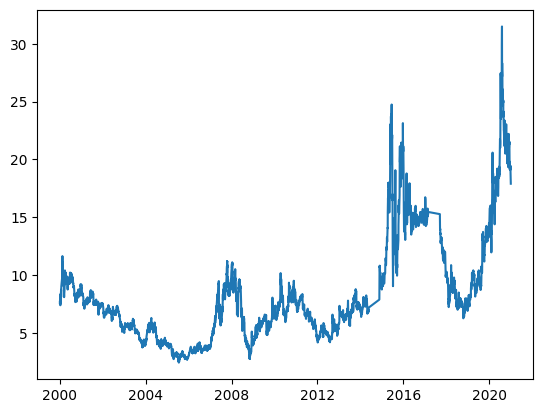

In [5]:
plt.plot(df.close)
plt.show()

In [11]:
class Actions(Enum):
    Hold = 0
    Sell = 1
    Buy = 2

In [25]:
class LStockDailyEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df=None):
        super(LStockDailyEnv, self).__init__()

        self.df = df
        self.current_step = NEXT_OBSERVATION_SIZE

        # self.reward_range = (0, MAX_ACCOUNT_BALANCE)
        # self.reward_range = (0, 1)
        # self.reward_range = (0, 100)
#         self.reward_range = (-np.inf, np.inf)
        self.reward_range = (-100, 100)

        self.action_space = spaces.Discrete(len(Actions))

        self.observation_space = spaces.Box(low=-1, high=1, shape=(14, NEXT_OBSERVATION_SIZE), dtype=np.float32)

    def seed(self, seed=None):
        pass


    def _next_observation(self):
        if self.df is None:
            return None

        # for i in range(NEXT_OBSERVATION_SIZE)
        #     self.df[:-self.current_step +].describe()

        frame = np.array([ # 11 * 10
            self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['open'].values / MAX_SHARE_PRICE,
            self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['high'].values / MAX_SHARE_PRICE,
            self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['low'].values / MAX_SHARE_PRICE,
            self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['close'].values / MAX_SHARE_PRICE,
            self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['volume'].values / MAX_NUM_SHARES,
            self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['amount'].values / MAX_NUM_SHARES,
            
            # self.df['close'].pct_change().fillna(0)[self.current_step: self.current_step + NEXT_OBSERVATION_SIZE],

            self.df['macd'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].values,
            self.df['macdh'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].values,
            self.df['macds'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].values,
            # # self.df['volume_delta'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # # self.df['open_2_d'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # # self.df['open_-2_r'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # # self.df['cr'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # # self.df['cr-ma1'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # self.df['cr-ma2'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # self.df['cr-ma3'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            self.df['kdjk'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].values,
            self.df['kdjd'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].values,
            self.df['kdjj'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].values,
            self.df['rsi_6'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].fillna(0).values,
            self.df['rsi_12'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].fillna(0).values,
            # self.df['open_2_sma'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # self.df['dma'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # self.df['pdi'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # self.df['mdi'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # self.df['dx'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # self.df['adx'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # self.df['adxr'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # self.df['tema'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # # self.df['vr'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # self.df['vr_6_sma'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,

            # self.df.iloc[self.current_step: self.current_step + NEXT_OBSERVATION_SIZE]['open'].values,
            # self.df.iloc[self.current_step: self.current_step + NEXT_OBSERVATION_SIZE]['high'].values,
            # self.df.iloc[self.current_step: self.current_step + NEXT_OBSERVATION_SIZE]['low'].values,
            # self.df.iloc[self.current_step: self.current_step + NEXT_OBSERVATION_SIZE]['close'].values,
            # self.df.iloc[self.current_step: self.current_step + NEXT_OBSERVATION_SIZE]['volume'].values,
        ])

        # if frame.shape[1] == 0:
        #     print(self.current_step)

        return frame

    def _take_action(self, action):
        if self.df is not None:
            current_price = self.df.iloc[self.current_step]['close'] # + 0.02

        # action_type = action[0]
        # amount = action[1]
        # amount = 1

        exchange_rate = 0.00015
        exchange_price = 0
        
        if action == Actions.Buy.value:
            # Buy amount % of balance in shares
            current_price = current_price + 0.02
            total_possible = int(self.balance / current_price)
            shares_bought = int(total_possible)
            prev_cost = self.cost_basis * self.shares_held
            additional_cost = shares_bought * current_price
            
            exchange_price = additional_cost
            self.balance -= additional_cost
            self.cost_basis = (prev_cost + additional_cost) / (self.shares_held + shares_bought)
            self.shares_held += shares_bought

        elif action == Actions.Sell.value:
            current_price = current_price - 0.02
            shares_sold = int(self.shares_held)
            
            exchange_price = shares_sold * current_price
            self.balance += shares_sold * current_price
            self.shares_held -= shares_sold
            self.total_shares_sold += shares_sold
            self.total_sales_value += shares_sold * current_price

        self.net_worth = self.balance + self.shares_held * current_price

        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

        # if self.shares_held == 0:
        #     self.cost_basis = 0
        return exchange_price

    def step(self, action):

        exchange_price = self._take_action(action)

        done = self.net_worth <= INITIAL_ACCOUNT_BALANCE * .9 or self.current_step + 1 >= self.df.shape[0] # or self.current_step % 5 == 0

        reward = 0
        obs = self._next_observation()
        if not done:
            if self.df is not None:
                if action == Actions.Buy.value: # Buy
                    reward = self.df.iloc[self.current_step + 1]['close'] - self.df.iloc[self.current_step]['close']
                elif action == Actions.Sell.value: # Sell
                    reward = self.df.iloc[self.current_step]['close'] - self.df.iloc[self.current_step + 1]['close']
                else: # Hold
                    reward = self.df.iloc[self.current_step + 1]['close'] - self.df.iloc[self.current_step]['close']
                    if self.shares_held < 1:
                        reward = 0

            if exchange_price <= 0 and action != Actions.Hold.value:
                reward = -reward
        
        else:
            reward = (self.net_worth - INITIAL_ACCOUNT_BALANCE)
        
        self.current_step = self.current_step + 1
        return obs, reward, done, {'net_worth': self.net_worth, 'current_step': self.current_step}

    def reset(self):
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.max_net_worth = INITIAL_ACCOUNT_BALANCE
        self.shares_held = 0
        self.cost_basis = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0

        if self.current_step > self.df.shape[0] - NEXT_OBSERVATION_SIZE:
            self.current_step = NEXT_OBSERVATION_SIZE

        return self._next_observation()

    def render(self, mode='human', close=False):
        profit = self.net_worth - INITIAL_ACCOUNT_BALANCE

        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(f'Shares held: {self.shares_held} (Total sold: {self.total_shares_sold})')
        print(f'Avg cost for held shares: {self.cost_basis} (Total sales value: {self.total_sales_value})')
        print(f'Net worth: {self.net_worth} (Max net worth: {self.max_net_worth})')
        print(f'Profit: {profit}')
        

In [29]:
env = DummyVecEnv([lambda: LStockDailyEnv(df)])
# model = PPO2(MlpPolicy, env, verbose=1) # , tensorboard_log='log')
model = PPO('MlpPolicy', env, verbose=1) # , tensorboard_log='log')
model.learn(60000)
# model = PPO1(LstmPolicy, env, verbose=1)
# model.learn(total_timesteps=1000)

# model.save('ppo_stock')
# model = PPO.load('ppo_stock')

Using cuda device
-----------------------------
| time/              |      |
|    fps             | 415  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 367          |
|    iterations           | 2            |
|    time_elapsed         | 11           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0098622525 |
|    clip_fraction        | 0.0538       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.09        |
|    explained_variance   | -0.000171    |
|    learning_rate        | 0.0003       |
|    loss                 | 8.68e+04     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00687     |
|    value_loss           | 1.54e+05     |
-----------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 323         |
|    iterations           | 13          |
|    time_elapsed         | 82          |
|    total_timesteps      | 26624       |
| train/                  |             |
|    approx_kl            | 0.009869793 |
|    clip_fraction        | 0.0574      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | -2.38e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 3.21e+06    |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00149    |
|    value_loss           | 2.79e+06    |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 323          |
|    iterations           | 14           |
|    time_elapsed         | 88           |
|    total_timesteps      | 2

-----------------------------------------
| time/                   |             |
|    fps                  | 324         |
|    iterations           | 24          |
|    time_elapsed         | 151         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.010064408 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.852      |
|    explained_variance   | 9.6e-06     |
|    learning_rate        | 0.0003      |
|    loss                 | 3.15e+03    |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.00377    |
|    value_loss           | 8.27e+03    |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 324          |
|    iterations           | 25           |
|    time_elapsed         | 157          |
|    total_timesteps      | 5

[1] [False]
Step: 11
Balance: 10000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 10000.0 (Max net worth: 10000)
Profit: 0.0
[1] [False]
Step: 12
Balance: 10000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 10000.0 (Max net worth: 10000)
Profit: 0.0
[1] [False]
Step: 13
Balance: 10000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 10000.0 (Max net worth: 10000)
Profit: 0.0
[1] [False]
Step: 14
Balance: 10000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 10000.0 (Max net worth: 10000)
Profit: 0.0
[1] [False]
Step: 15
Balance: 10000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 10000.0 (Max net worth: 10000)
Profit: 0.0
[1] [False]
Step: 16
Balance: 10000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0

[1] [False]
Step: 80
Balance: 10000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 10000.0 (Max net worth: 10000)
Profit: 0.0
[1] [False]
Step: 81
Balance: 10000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 10000.0 (Max net worth: 10000)
Profit: 0.0
[1] [False]
Step: 82
Balance: 10000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 10000.0 (Max net worth: 10000)
Profit: 0.0
[1] [False]
Step: 83
Balance: 10000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 10000.0 (Max net worth: 10000)
Profit: 0.0
[1] [False]
Step: 84
Balance: 10000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 10000.0 (Max net worth: 10000)
Profit: 0.0
[1] [False]
Step: 85
Balance: 10000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0

[1] [False]
Step: 150
Balance: 10000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 10000.0 (Max net worth: 10000)
Profit: 0.0
[1] [False]
Step: 151
Balance: 10000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 10000.0 (Max net worth: 10000)
Profit: 0.0
[1] [False]
Step: 152
Balance: 10000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 10000.0 (Max net worth: 10000)
Profit: 0.0
[1] [False]
Step: 153
Balance: 10000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 10000.0 (Max net worth: 10000)
Profit: 0.0
[1] [False]
Step: 154
Balance: 10000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 10000.0 (Max net worth: 10000)
Profit: 0.0
[1] [False]
Step: 155
Balance: 10000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales valu

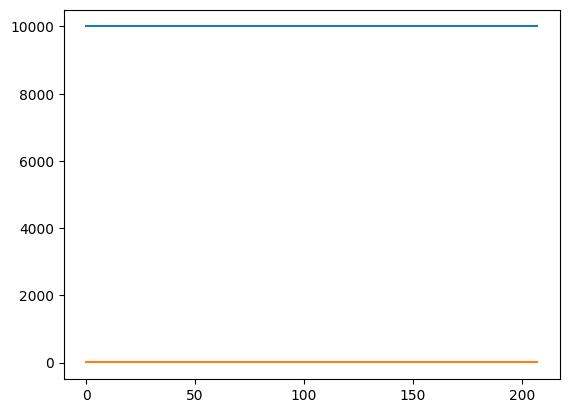

In [30]:
eval_env = DummyVecEnv([lambda: LStockDailyEnv(df_eval)])
obs = eval_env.reset()

net_worths = []
actions = []
done, state = False, None
# while not done:
for _ in range(NEXT_OBSERVATION_SIZE, df_eval.shape[0]):
    action, state = model.predict(obs, state=state, deterministic=True)
    obs, reward, done, _info = eval_env.step(action)
    print(action, done)
    net_worths.append(_info[0]['net_worth'])
    # if is_recurrent:
    #     obs[0, :] = new_obs
    # else:
    #     obs = new_obs

    # if action[0] < Actions.Buy: # Buy
    #     actions.append(1)
    # elif action[0] < Actions.Sell: # Sell
    #     actions.append(2)
    # else:
    #     actions.append(0)
    actions.append(action[0])
    eval_env.render()

plt.plot(net_worths)
plt.plot(actions)
plt.show()

# fig, ax = plt.subplots()
# # ax.plot(rewards, label='rewards')
# ax.plot(actions, '.', label='actions')
# # ax.legend()
# ax2 = ax.twinx()
# ax2.plot(net_worths, label='net worth', color='red')
# ax2.legend()
# plt.show()

# tensorflow 2.6

In [31]:
actions

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]